# Sales Prediction

In [1]:
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Read Dataset

Reads the dataset from json file, transforming into dataframe. Only columns related to sales prediction will keep on.
 - **register_date**: to treat data as a time series;
 - **item_total_price**: to keep it simple, this information will be used as time series and monthly summed. It will be easier to use it, instead of total_price, because total_price is replicated over different lines.

In [2]:
data = pd.read_json('challenge.json')

keep_columns = [
    'item_total_price',
    'register_date'
]

data = data[keep_columns]
data['register_date'] = data.register_date.apply(lambda x: datetime.strptime(x[:10],'%Y-%m-%d'))
data['year'] = data.register_date.apply(lambda x: x.year)
data['month'] = data.register_date.apply(lambda x: x.month)
print(data.shape)
data.head().T

(204428, 4)


,0,1,2,3,4
item_total_price,292.91,287.19,184.84,189.18,66.87
register_date,2017-11-10 00:00:00,2011-05-16 00:00:00,2018-01-24 00:00:00,2010-07-28 00:00:00,2010-12-17 00:00:00
year,2017,2011,2018,2010,2010
month,11,5,1,7,12


# Monthly Sales

Sum the sales over each month/year and decompose the serie into trend, seasonal and residual components.
Looking at trend component, it is possible to see the sales income is increasing over the years, showing the business is possibly growing.
At the seasonal component, it is possible to see a peak sales over february, march, september and october. It indicates a need to increse the stock over those months.

In [6]:
sales = data[['year', 'month', 'item_total_price']]
month_sales = sales.groupby(['year', 'month'])['item_total_price'].sum()

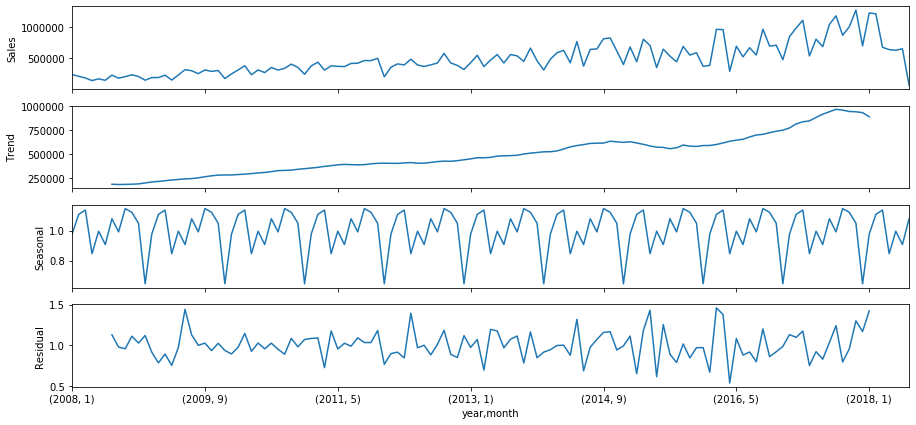

In [7]:
month_dec = seasonal_decompose(month_sales, model='multiplicative', freq=12)

plt.figure(figsize=(15,7))

ax = plt.subplot(4,1,1)
ax.set_ylabel('Sales')
month_dec.observed.plot()

ax = plt.subplot(4,1,2,sharex=ax)
ax.set_ylabel('Trend')
month_dec.trend.plot(ax=ax)

ax = plt.subplot(4,1,3,sharex=ax)
ax.set_ylabel('Seasonal')
month_dec.seasonal.plot(ax=ax)

ax = plt.subplot(4,1,4,sharex=ax)
ax.set_ylabel('Residual')
month_dec.resid.plot(ax=ax)

Here, the plot is showing a complete agreement between month sales from 2008 to 2018.

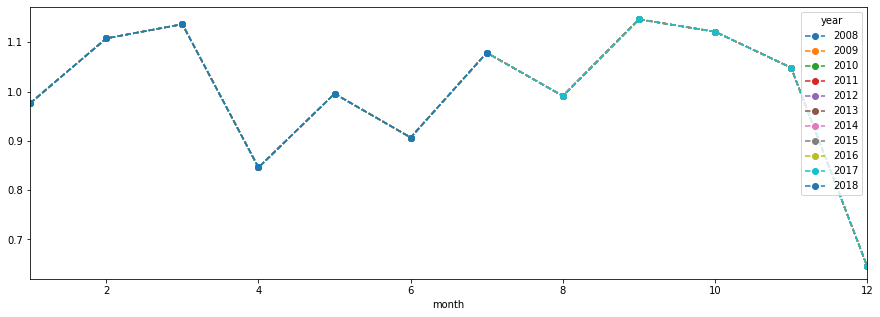

In [8]:
plt.figure(figsize=(15,5))
ax = plt.subplot()
month_dec.seasonal.unstack('month').T.plot(ax=ax, linestyle='dashed', marker='o')

# Model

In this part of the problem a time series model (sarima) will be built. Fist, the time series will be split into train and test. This split was chosen because it separates aproximately 70% for training and 30% for testing.

- Train: from 2008 to 2015
- Test:  from 2016 to 2018

Because the values are monetary, they will be transformed to log. It tends to improve the model. After the prediction is complete, the values will be transformed back to monetary scale.

In [28]:
train_months = np.log1p(month_sales.to_frame().query('year <= 2015'))
test_months = np.log1p(month_sales.to_frame().query('year > 2015'))
print('train size:', train_months.shape)
print('test size:', test_months.shape)

train size: (96, 1)
test size: (31, 1)


The parameters of the model are selected based on time series frequency, wich is 12.

In [31]:
%%capture
model = SARIMAX(train_months, order=(12, 1, 12), seasonal_order=(12,1,12,1))
results = model.fit()

# Results

The mean absolute error was chosen becouse it represents the real monetary error. The error and the plot are using monetary scale.

It seems that the model is doing a good aproximation. Even thoug it is doing a better aproximation over fist half values, it is not capturing the trend component for the second half of the serie.

In [34]:
%%capture --no-stdout

# true test values
y_true = np.expm1(test_months)

# predicts the n trest points and transform to monetary scale
pred = results.predict(len(train_months),len(train_months)+len(test_months))[1:]
pred = np.expm1(pred)

print('SARIMA model MAE:{}'.format(mean_absolute_error(y_true,pred)))

SARIMA model MAE:247377.62543574325


### Prediction vs Test

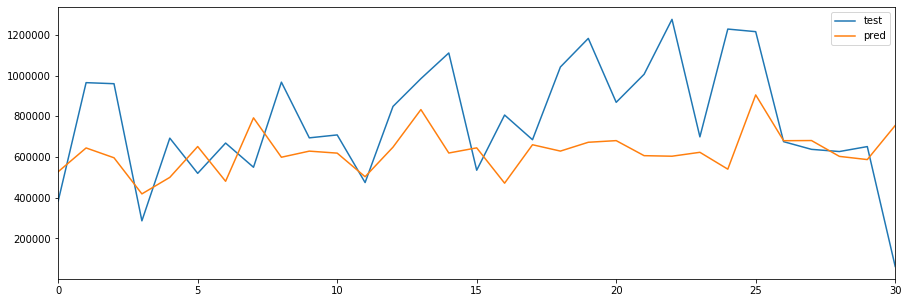

In [33]:
plt.figure(figsize=(15,5))
ax = plt.subplot()
pd.DataFrame({'test':y_true.item_total_price.values,'pred':pred.values}).plot(ax=ax)
plt.show()